# Bcubed precision and recall

* Definition in *Amigó E, Gonzalo J, Artiles J et alA comparison of extrinsic clustering evaluation metrics based on formal constraints.   Information Retrieval. 12. 461-486. 10.1007/s10791-008-9066-8.*

![](BCPR.png)


1. On the web you can quickly find definitions of bcubed precision and recall: see eg <https://www.researchgate.net/figure/Example-of-computing-the-BCubed-precision-and-recall-for-one-item_fig10_225548032> for a nice picture.
2. Your function  will have as input two vectors: true and predicted. 
3. The sum of the values in that list equals the numbefr of pages of the PDF file.
4. The  length of that list is the number of documents in the PDF file
5. The numbers in the list indicate the lengths of the documents. So L[i] gives the length in number of pages of the i-th document in the PDF file.
6. You find an example on `DocumentSplitting/data/WobGelderland/Doclengths_of_the_individual_docs.json` for the files in `/DocumentSplitting/data/WobGelderland/ConcatenatedPDFS`  
 

### baselines

* every page starts a new doc ([1,1,1,1,......])
* there is only one doc  ([X]) for X the length of the compolete document
* but also more informed ones, like the mode and the median of the true splits 
 

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
%matplotlib inline


In [2]:
# examples
vb_truth, vb_pred = [1,2,1,3,3,5], [1,1,2,3,4,4]

In [3]:
def make_index(split):
    '''Turns a doc length vector like [1,2,1,3,3,5] into a dict with pagenumbers as keys and the set of all 
    pagenumbers in the same document as value.
    This thus is an index which gives for every page its cluster.'''
    l= sum(split)
    pages= list(np.arange(l))
    out = defaultdict(set)
    for block_length in split:
        block= pages[:block_length]
        pages= pages[block_length:]
        for page in block:
            out[page]= set(block)
    return out

#test
make_index(vb_truth)
#tests

defaultdict(set,
            {0: {0},
             1: {1, 2},
             2: {1, 2},
             3: {3},
             4: {4, 5, 6},
             5: {4, 5, 6},
             6: {4, 5, 6},
             7: {7, 8, 9},
             8: {7, 8, 9},
             9: {7, 8, 9},
             10: {10, 11, 12, 13, 14},
             11: {10, 11, 12, 13, 14},
             12: {10, 11, 12, 13, 14},
             13: {10, 11, 12, 13, 14},
             14: {10, 11, 12, 13, 14}})

In [5]:
def Bcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    truth,pred = make_index(truth), make_index(pred)
    
    df  ={i:{'size':len(truth[i]),'P':0,'R':0,'F1':0} for i in truth}
    for i in truth:
        df[i]['P']= len(truth[i] & pred[i])/len(pred[i]) 
        df[i]['R']= len(truth[i] & pred[i])/len(truth[i])
        df[i]['F1']= (2*df[i]['P']*df[i]['R'])/(df[i]['P']+df[i]['R'])
    df= pd.DataFrame.from_dict(df, orient='index')
    df.index_name='PageNr'
    return  df


def MeanBcubed(truth,pred):
    assert sum(truth)==sum(pred)  # same amount of pages
    return Bcubed(truth,pred).mean()


print(MeanBcubed(vb_truth,vb_pred))

Bcubed(vb_truth,vb_pred)


size    3.266667
P       0.833333
R       0.826667
F1      0.812169
dtype: float64


,size,P,R,F1
0,1,1.00,1.0,1.000000
1,2,1.00,0.5,0.666667
2,2,0.50,0.5,0.500000
3,1,0.50,1.0,0.666667
4,3,1.00,1.0,1.000000
5,3,1.00,1.0,1.000000
6,3,1.00,1.0,1.000000
7,3,0.75,1.0,0.857143
8,3,0.75,1.0,0.857143
9,3,0.75,1.0,0.857143


# On corpus

* baseline is fixed cluster/document size with all the median pagelength

In [6]:
f= open('../corpus1/TrainTestSet/Trainset/Doclengths_of_the_individual_docs_TRAIN.json')
truth_corpus=json.load(f)

             size           P           R          F1
count  113.000000  113.000000  113.000000  113.000000
mean    17.871638    0.712924    0.661530    0.558666
std     28.744391    0.222856    0.286707    0.226605
min      1.000000    0.205128    0.039516    0.076014
25%      3.000000    0.520000    0.389199    0.415518
50%      6.000000    0.757764    0.739886    0.536119
75%     17.547368    0.912985    0.894737    0.666667
max    151.000000    1.000000    1.000000    1.000000


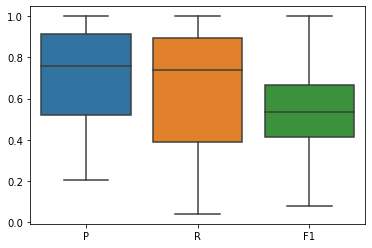

In [7]:
def fixedpage(truth,docsize=3):
    number_of_blocks= sum(truth)//docsize
    rest = sum(truth) % docsize
    if rest !=0:
        return [docsize for _ in range(number_of_blocks)]+[rest]
    else:
        return [docsize for _ in range(number_of_blocks)]  
    
D ={pdf: MeanBcubed(truth_corpus[pdf], fixedpage(truth_corpus[pdf],6))
   for pdf in truth_corpus}
results= pd.DataFrame.from_dict(D,orient='index')
print(results.describe())
sns.boxplot(data=results[['P','R','F1']]);    

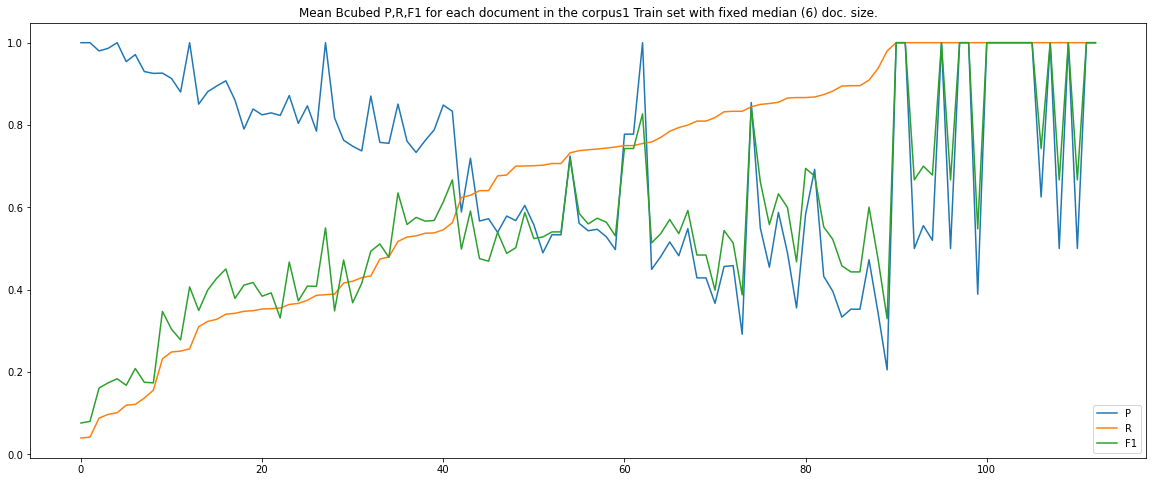

In [8]:
title='Mean Bcubed P,R,F1 for each document in the corpus1 Train set with fixed median (6) doc. size.'
results[['P','R','F1']].sort_values('R').reset_index().plot( title=title,
                                               figsize=(20,8));

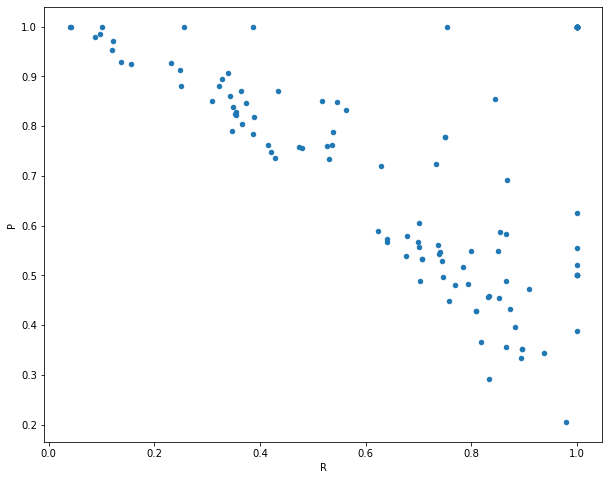

In [9]:
results.plot.scatter(x='R', y='P', figsize=(10,8));